<a href="https://colab.research.google.com/github/Doppler-67/taxi-orders-forecasting/blob/main/taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing libraries**

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

In [42]:
sns.set()

In [43]:
np.random.seed(67)

#**Data understanding**

In [44]:
data = pd.read_csv('/content/drive/MyDrive/taxi_orders_forecasting/taxi.csv')

In [45]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [47]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


#**Data preparation**

Для начала приведем колонку datetime к нужному типу и сделаем ее индексом.

In [48]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [49]:
data = data.set_index('datetime').sort_index()

Выполним ресемплирование, чтобы временной промежуток между строками равнялся одному часу.

In [50]:
data = data.resample('1H').sum()

Посмотрим на предобработанные данные.

In [51]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#**EDA**

Визуализируем данные и изучим тренд.

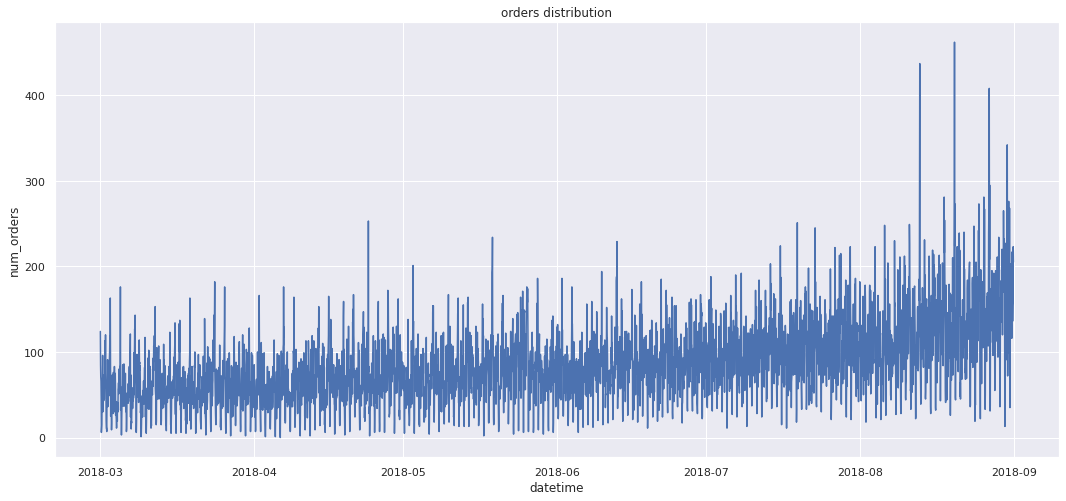

In [54]:
plt.figure(figsize=(18, 8))

sns.lineplot(x=data.index, y=data['num_orders'])
plt.title('orders distribution')

plt.show()

In [65]:
decomposed = seasonal_decompose(data['num_orders'])

По графику тренда видно, что спрос на такси планомерно возрастает.

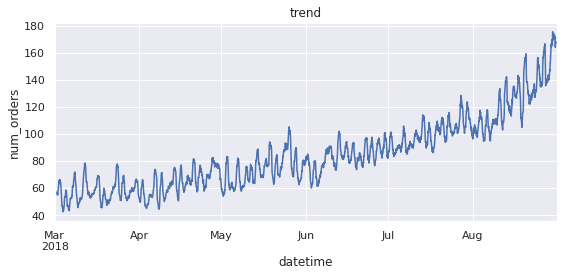

In [71]:
plt.figure(figsize=(8, 4))
decomposed.trend.plot(ax=plt.gca())
plt.title('trend')
plt.ylabel('num_orders')
plt.tight_layout()

# **Feature engeneering**

Реализуем добавление новых признаков с помощью фукнции.

In [75]:
def add_features(data, amount_of_lags=6, rolling_window=6):
    modified_data = data.copy()
    modified_data['day'] = data.index.day
    modified_data['day_of_week'] = data.index.dayofweek
    
    for i in range(1, amount_of_lags+1):
        modified_data['lag_{}'.format(i)] = modified_data['num_orders'].shift(i)
        
    modified_data['rolling_mean_1'] = modified_data['num_orders'].shift().rolling(rolling_window).mean()
    
    modified_data = modified_data.dropna()
    
    return modified_data
    

In [76]:
modified_data = add_features(data)

In [77]:
modified_data.head()

,num_orders,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean_1
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,1,3,6.0,43.0,66.0,71.0,85.0,124.0,65.833333
2018-03-01 07:00:00,15,1,3,12.0,6.0,43.0,66.0,71.0,85.0,47.166667
2018-03-01 08:00:00,34,1,3,15.0,12.0,6.0,43.0,66.0,71.0,35.500000
2018-03-01 09:00:00,69,1,3,34.0,15.0,12.0,6.0,43.0,66.0,29.333333
2018-03-01 10:00:00,64,1,3,69.0,34.0,15.0,12.0,6.0,43.0,29.833333
